# Import data list

In [1]:
import sys
sys.path.append("/Users/sst/project/Myscripts")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from myscripts.myplot import *
import myscripts.helper as H


DF = pd.read_csv("data_info.csv", index_col=0)
print(DF.index)
print(DF.columns)

Index(['JBNP31', 'JBNP32L', 'JBNP32', 'JBNP33L', 'JBNP33'], dtype='object', name='sample')
Index(['iq', 'sq', 'fq', 'gr', 'fgr0', 'fgr1', 'fgr2', 'csv0', 'csv1', 'csv2',
       'color', 'fgr3', 'csv3', 'fgr4', 'csv4', 'fgr_ana', 'csv_ana',
       'fgr_pbo', 'csv_pbo', 'fgr_rut', 'csv_rut', 'fgr_bro', 'csv_bro',
       'csv_ana_fix', 'fgr_ana_fix', 'moving_pearson', 'pearson_25A',
       'csv_twop', 'fgr_twop', 'csv_proxy', 'fgr_proxy', 'csv_sinwave',
       'fgr_sinwave', 'csv_two_phase', 'fgr_two_phase',
       'csv_two_phase_sine_wave', 'fgr_two_phase_sine_wave',
       'csv_one_phase_logsp', 'fgr_one_phase_logsp', 'csv_two_phase_logsp',
       'fgr_two_phase_logsp', 'final_csv', 'final_fgr'],
      dtype='object')


In [3]:
def get_rw_from_csv(col: str) -> list:
    return [pd.read_csv(csv, index_col=0).iloc[0, 0] for csv in DF[col]]

In [4]:
savefig = H.set_savefig(savedir="/Users/sst/project/papers/19st_tio2b/figure")

In [5]:
if True:  # use group style
    plt.style.use("/Users/sst/visual.mplstyle")

## samples

Below is the samples information:

In [6]:
SAM = pd.DataFrame()
SAM["sample"] = DF.index
SAM.set_index("sample", inplace=True)
SAM["psize ($\AA$)"] = [55, 30, 30, 75, 75]
SAM["have ligands"] = ["No", "Yes", "No", "Yes", "No"]

lab = "sample_information"
cap = "Sample information. The 'psize' is the average particle size measured by TEM. " +\
"Samples whose label contains 'L' means there are ligands in samples."
H.to_latex(SAM, label=lab, caption=cap)

\begin{table}[htb]
\caption{Sample information. The 'psize' is the average particle size measured by TEM. Samples whose label contains 'L' means there are ligands in samples.}
\label{tab:sample_information}
\begin{tabular}{lrl}
\hline\hline
{} &  psize ($\AA$) & have ligands \\
sample  &                &              \\
\hline
JBNP31  &             55 &           No \\
JBNP32L &             30 &          Yes \\
JBNP32  &             30 &           No \\
JBNP33L &             75 &          Yes \\
JBNP33  &             75 &           No \\
\hline\hline
\end{tabular}
\end{table}


# Plot gr data

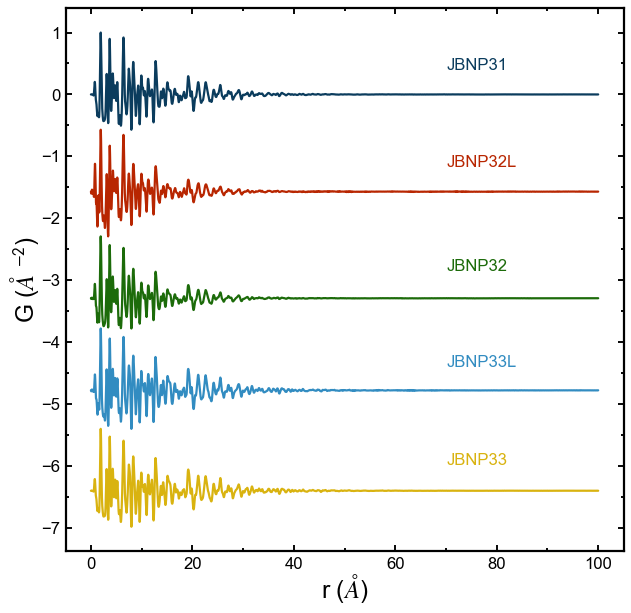

In [7]:
fig = plot_gr(DF["gr"], names=DF.index, normal=True, colors=DF["color"])

# One Bronze phase Fitting

\begin{figure}[htb]
\includegraphics[width=\columnwidth]{one_phase_fitting.pdf}
\caption{}
\label{fig:one_phase_fitting}
\end{figure}


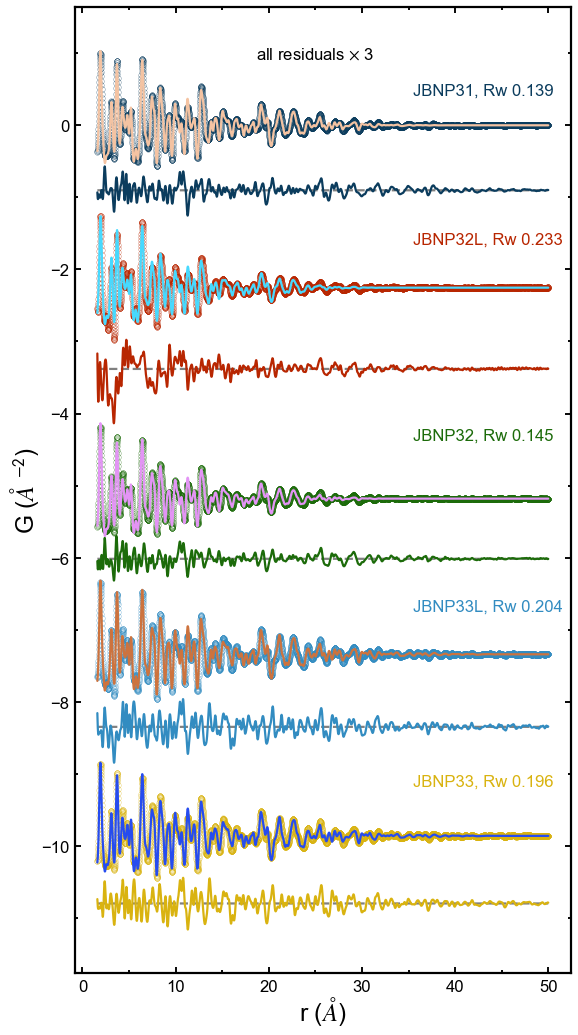

In [8]:
# plot the fitted curves, residuals are multiplied by three.
fgrs = DF["fgr2"].to_list()
rws = get_rw_from_csv("csv2")
samples = DF.index

plt.figure(figsize=(8, 16))
plot_fgr(fgrs, rws=rws, names=samples, colors=DF["color"],
         normal=True, apos=(.7, .3), rwpos=", ", res_scale=3.0)
plt.annotate(r"all residuals $\times$ 3", xy=(25, 1), ha="center", va="center")

if True:
    savefig("one_phase_fitting")
    
plt.show()

In [9]:
# plot the residual function
def plot_rw(fgrs, colors=None, normal=False, names=None, apos=(.7, .3)):
    rs, _, _, gdiffs = H.load_fgr(fgrs)
    
    if normal:
        gdiffs = H.normalized(gdiffs)
    else:
        pass
    
    H.shift_data(gdiffs)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    lines = H.add_solidlines(ax, rs, gdiffs)
    
    if colors is not None:
        H.paint_color(lines, colors)
    else:
        pass
    
    if names is not None:
        poss = H.calc_poss(rs, gdiffs, apos)
        H.annotate_plots(ax, names=names, poss=poss)
    else:
        pass
    
    return

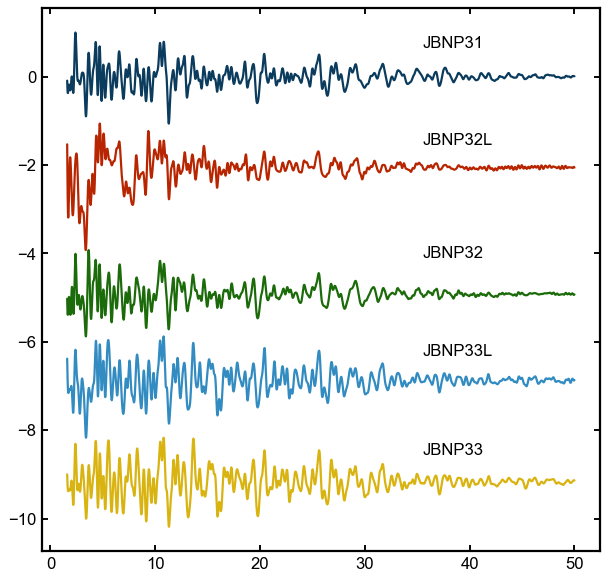

In [10]:
# plot residual
plot_rw(fgrs, colors=DF["color"], names=DF.index, normal=True)

#### Common feature:

The fitting mostly has a Rw around .2 level. Their residuals have similar pattern except JBNP32L. There has been enough paramters freed in the fitting so the residuals are signal that cannot be included by one phase AMC model.

#### Special feature:

There is a larger Rw for JBNP32L and a base line in its residual curve.

#### Questions:

Where is the residual from? The other minor phase or certain kinds of defect?

Why is there a base line in JBNP32L?

#### Discussion with Simon

The high-r region residuals probably are probably just a part of a signal. It is caused by the misfit of the characteristic functions. This can be tested when calculating the correlation between the signal and residuals.

The low-r region residuals for the ligand ones have a low frequency signal because there is density modulation from the organic ligands.

The low-r region residuals peaks may from a part of signal or a different phase. Try to calculate correlation to see if it is from signal because of the misfit of characteristic function. If not, they may come from another phase.

## Check similarity between residual and data

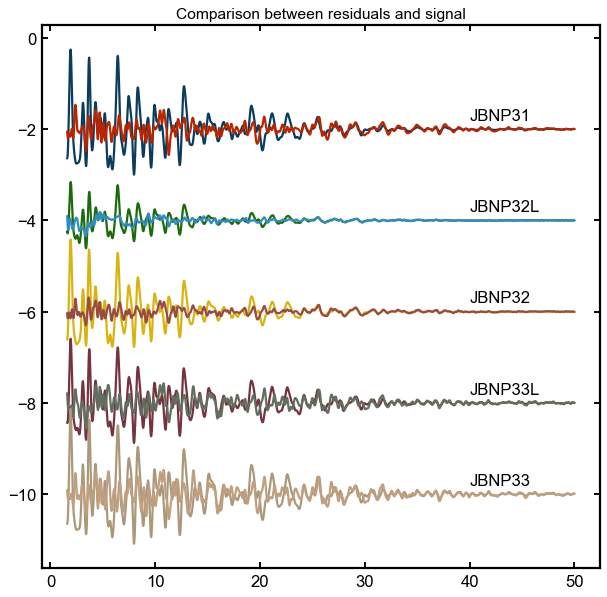

In [12]:
# data v.s. scaled residuals

fgr_files = DF["fgr2"].to_list()
sample_names = DF.index.to_list()
rs, _, gs, gdiffs = H.load_fgr(fgr_files)

shift = 0.
for r, g, gdiff, sample_name in zip(rs, gs, gdiffs, sample_names):
    scale = g[r > 25.].max() / gdiff[r > 25.].max()
    shift += 2.
    plt.plot(r, g - shift)
    plt.plot(r, gdiff * scale - shift)
    plt.annotate(sample_name, xy=(40, -shift + 0.2))

plt.title("Comparison between residuals and signal")    
plt.show()

The residual in r > 25 A are highly alike the data. This part of residuals may be caused by the misfit of characteristic functions.

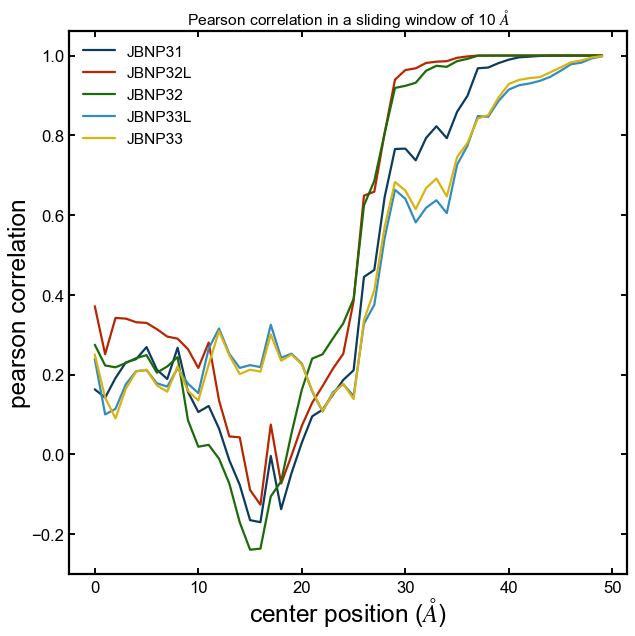

In [13]:
centerss, pcss = H.load_xy(DF["moving_pearson"])
samples = DF.index.to_list()

fig, ax = plt.subplots()
for centers, pcs, sample in zip(centerss, pcss, samples):
    ax.plot(centers, pcs, label=sample)

ax.set_xlabel(r"center position ($\AA$)")
ax.set_ylabel(fr"pearson correlation")
ax.legend(loc=2)
plt.title(r"Pearson correlation in a sliding window of 10 $\AA$")
plt.show()

Pearson correlation rises around 25 A. The residuals are similar to data after 25A.

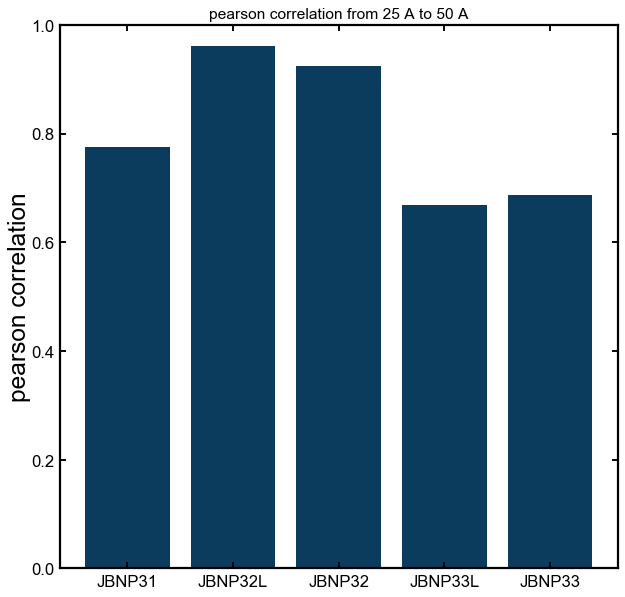

In [14]:
fig, ax = plt.subplots()
ax.bar(np.arange(len(DF.index)) , height=DF["pearson_25A"])

ax.set_ylabel("pearson correlation")
ax.set_ylim(0, 1)

ticks = [""] + DF.index.to_list()
ax.set_xticklabels(ticks)

plt.title("pearson correlation from 25 A to 50 A")
plt.show()

The pearson correlation is high in after 25 A, which further confirms the high-r residuals are similar to the data. The residuals may comes from the incorrect characteristic function.

### Discussion with Simon

Fit the 25 A ~ 50 A with Bronze phase model and then keep the fitting results and used it as parameters in a fitting with two Bronze phases model in 0 A ~ 50 A. Fix the parameters and only free the variables in the other phase to get the fitting.

# Two phase fitting

## check which phase gives lowest Rw

In [15]:
# read one phase fitting Rw
rws0 = []
samples = ["JBNP31", "JBNP32", "JBNP33L", "JBNP33"]
phases = ["Anatase", "Rutile", "Brookite", "PbO2a"]
for sample in samples:
    csv = DF.loc[sample, "csv2"]
    df = pd.read_csv(csv, index_col=0)
    rws0.append(df.loc["Rw", "val"])
rws0 = np.array(rws0)

# get a matrix of rw of two phase
mat = []
for sample in samples:
    row = []
    for col in ["csv_ana", "csv_rut", "csv_bro", "csv_pbo"]:
        csv = DF.loc[sample, col]
        df = pd.read_csv(csv, index_col=0)
        row.append(df.iloc[0, 0])
    mat.append(row)
mat = np.array(mat)

# get a matrix of difference of rw between two phase and one phase
def sub_col(col: np.array) -> np.array:
    return col - rws0

diffmat = np.apply_along_axis(sub_col, 0, mat).T

\begin{figure}[htb]
\includegraphics[width=\columnwidth]{diff_rw_matrix.pdf}
\caption{}
\label{fig:diff_rw_matrix}
\end{figure}


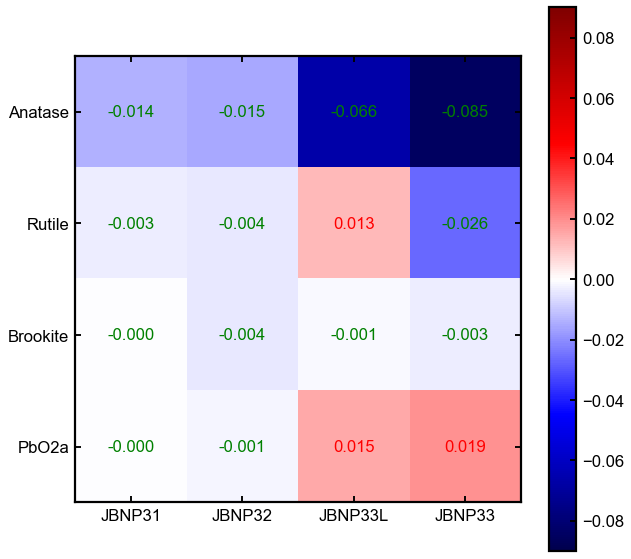

In [16]:
# plot mat as color
fig, ax = plt.subplots()

img = ax.imshow(diffmat, cmap="seismic", vmin=-.09, vmax=.09)
ax.set_xticks([-0.5, 0, 1, 2, 3, 3.5])
xticks = [""] + samples + [""]
ax.set_xticklabels(xticks)
ax.set_yticks([-0.5, 0, 1, 2, 3, 3.5])
yticks = [""] + phases + [""]
ax.set_yticklabels(yticks)
plt.colorbar(img)

# add number to pixel
width, height = diffmat.shape
for x in range(width):
    for y in range(height):
        val = diffmat[x, y]
        plt.annotate(f"{val:.3f}", xy=(y, x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color= "g" if val <= 0 else "r")
        
if True:
    savefig("diff_rw_matrix")

plt.show()

The Anatase phase wins for all samples!

## Check similarity between residual and data

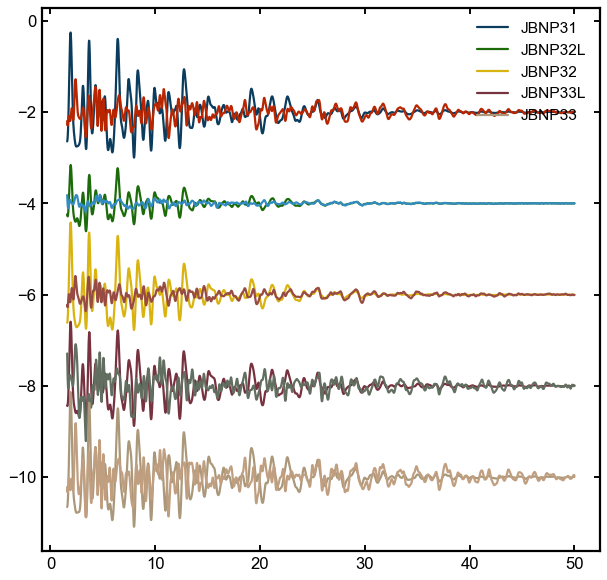

In [17]:
fgr_files = DF["fgr_ana"].to_list()
sample_names = DF.index.to_list()
rs, _, gs, gdiffs = H.load_fgr(fgr_files)

fig, ax = plt.subplots()

shift = 0.
for r, g, gdiff, sample_name in zip(rs, gs, gdiffs, sample_names):
    scale = g[r > 25.].max() / gdiff[r > 25.].max()
    shift += 2.
    ax.plot(r, g - shift, label=sample_name)
    ax.plot(r, gdiff * scale - shift)
    ax.legend(loc=1)

There is similarity between data and residuals in r > 25 A. The residuals in r > 25 A comes from the inaccurate characteristic function. There may be a distribution of particle size with observable standard deviation and there are more population in larger particle size than average size.

## analyze fitting result

In [18]:
csvs = [pd.read_csv(csv, index_col=0) for csv in DF["csv_ana"]]
DFres = pd.concat(csvs, axis=1)
DFres.columns = DF.index.to_list()
print(DFres.round(3).to_string())

                 JBNP31  JBNP32L   JBNP32  JBNP33L   JBNP33
Rw                0.125    0.176    0.130    0.137    0.112
psize_Bronze     39.900   33.882   33.611   47.867   46.647
scale_Bronze      0.500    0.247    0.470    0.357    0.474
delta2_Bronze     2.444    2.694    2.384    2.966    2.022
a_Bronze         12.184   12.226   12.192   12.188   12.186
b_Bronze          3.746    3.760    3.747    3.750    3.747
c_Bronze          6.495    6.459    6.493    6.489    6.501
beta_Bronze     106.996  107.086  107.022  107.011  107.007
U33_0_Bronze      0.007    0.010    0.008    0.006    0.006
U13_0_Bronze      0.002    0.003    0.002    0.002    0.002
U11_0_Bronze      0.007    0.010    0.008    0.006    0.006
U22_0_Bronze      0.007    0.010    0.008    0.006    0.006
U33_4_Bronze      0.007    0.008    0.007    0.007    0.006
U13_4_Bronze      0.002    0.002    0.002    0.002    0.002
U11_4_Bronze      0.007    0.008    0.007    0.007    0.006
U22_4_Bronze      0.007    0.008    0.00

There is large ADP, large delta and large distortion for JBNP32L. Probably the model try to learn the information of the density modulation so that it wants the calculated curve to be smooth. Try to extract this density modulation singal and then try a fit.

### Discussion with Simon

Remove the density modulation and fit the PDF again to see if the results go back to normal.

# One Bronze phase with two psize

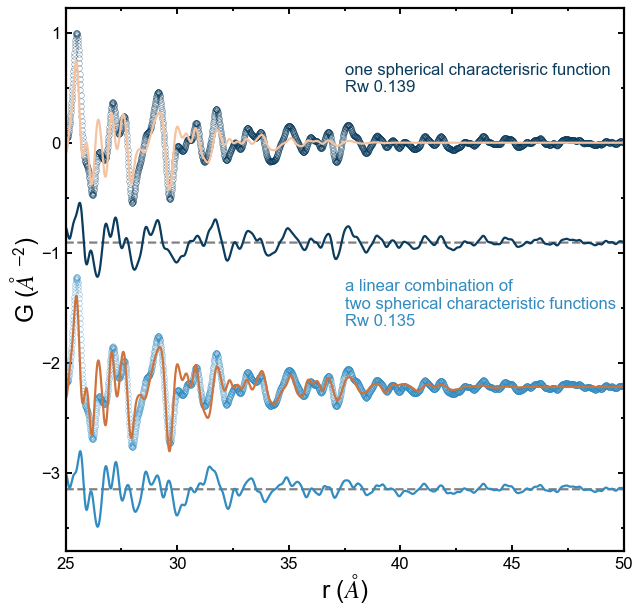

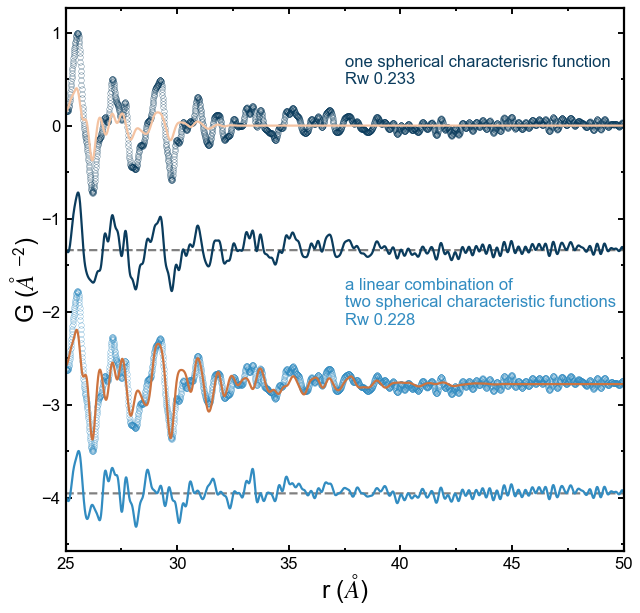

\begin{figure}[htb]
\includegraphics[width=\columnwidth]{two_psize_fit_JBNP32.pdf}
\caption{}
\label{fig:two_psize_fit_JBNP32}
\end{figure}


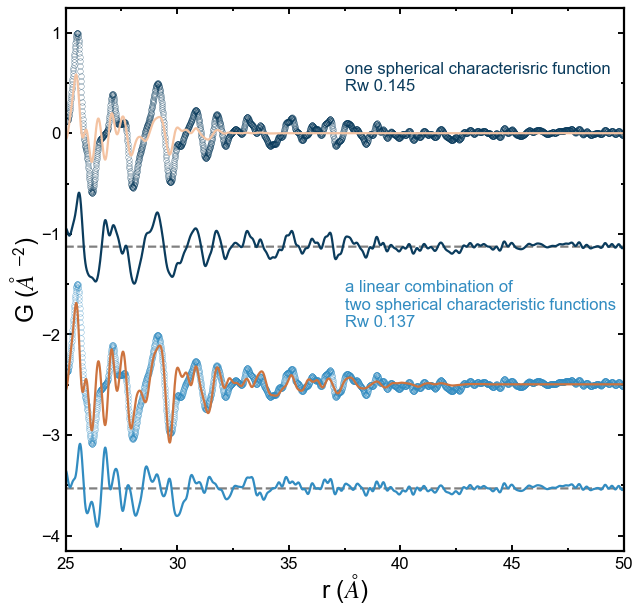

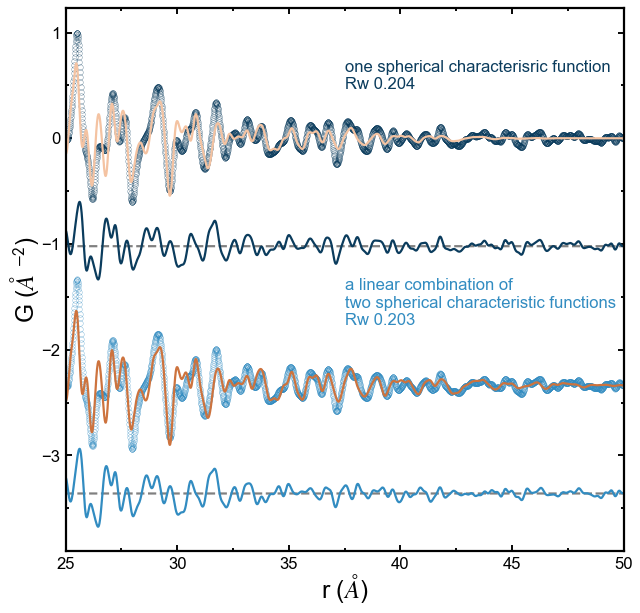

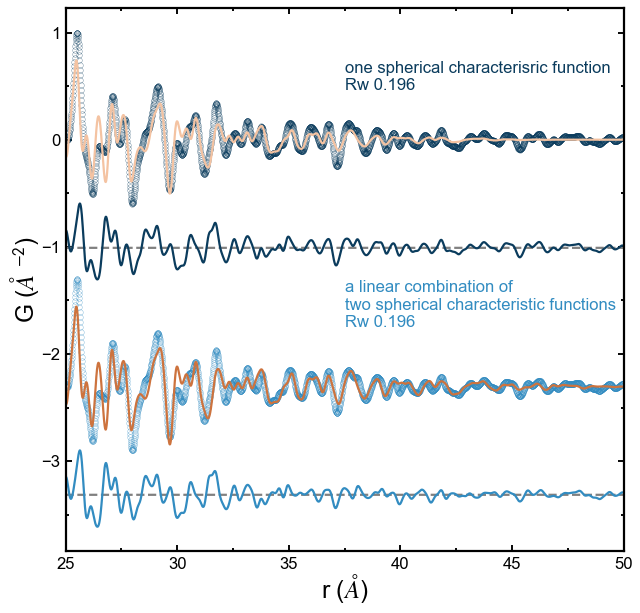

In [19]:
names = DF.index
rws0 = get_rw_from_csv("csv2")
rws1 = get_rw_from_csv("csv_twop")

for sample,fgr0, rw0, fgr1, rw1 in zip(DF.index, DF["fgr2"], rws0, DF["fgr_twop"], rws1):
    names = ["one spherical characterisric function",
             "a linear combination of\ntwo spherical characteristic functions"]
    colors = ["#0B3C5D", "#328CC1"]
    plot_fgr([fgr0, fgr1], rlim=(25, 50), normal=True, rws=[rw0, rw1], apos=(.5, .3), names=names, colors=colors)
    if sample == "JBNP32":
        savefig("two_psize_fit_JBNP32")
    plt.show()

The Rw does not decrease much but the high-r peaks are fitted by the new characteristic function. The high-r peaks only contribute to a small propotion in Rw but those peaks is important and tells us about the distribution of particle size. The two psize size fitting is accepted.

The two psize results show that the distribution of particle size is not a sharp peak distribution centered at average size but there is longer tail in larger particle size

# Extract the density modulation

\begin{figure}[htb]
\includegraphics[width=\columnwidth]{sine_wave_fitting.pdf}
\caption{}
\label{fig:sine_wave_fitting}
\end{figure}


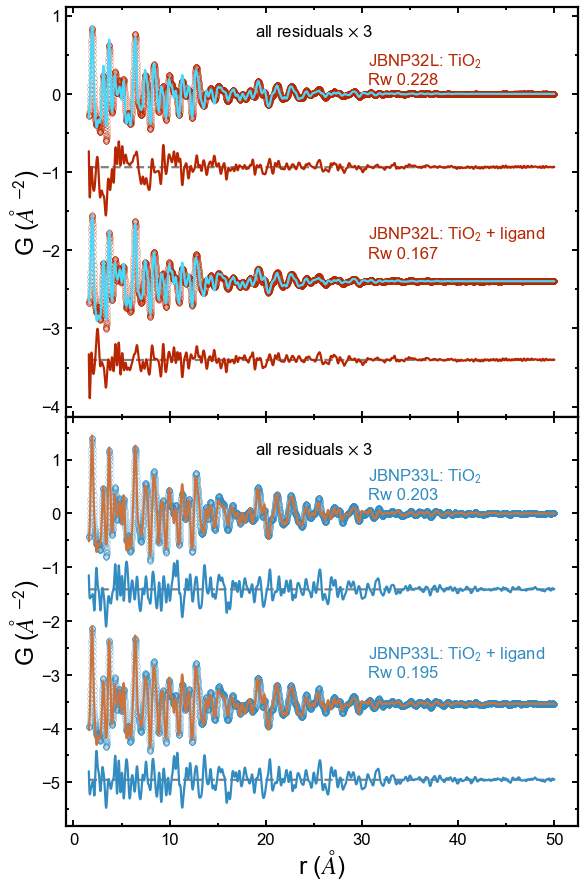

In [20]:
samples = ["JBNP32L", "JBNP33L"]

fig = plt.figure(figsize=(8, 3.2 * 4))
axposs = ([.1, .5, .8, .4], [.1, .1, .8, .4])
vans = [0.8, 1.2]
for sample, axpos, fgr0, fgr1, van in zip(samples, axposs, DF.loc[samples, "fgr_twop"], DF.loc[samples, "fgr_sinwave"], vans):
    fig.add_axes(axpos)
    tio2 = r"TiO$_2$"
    names = [f"{sample}: {tio2}", f"{sample}: {tio2} + ligand"]
    colors = [DF.loc[sample, "color"], DF.loc[sample, "color"]]
    plot_fgr([fgr0, fgr1], auto_rw=True, apos=(.6, .2), res_scale=3.0, names=names, colors=colors)
    plt.annotate(r"all residuals $\times$ 3", xy=(25, van), ha="center", va="center")

if True:
    savefig("sine_wave_fitting")

### Fit with Bronze (two-psize) + Anatase + (sine wave)

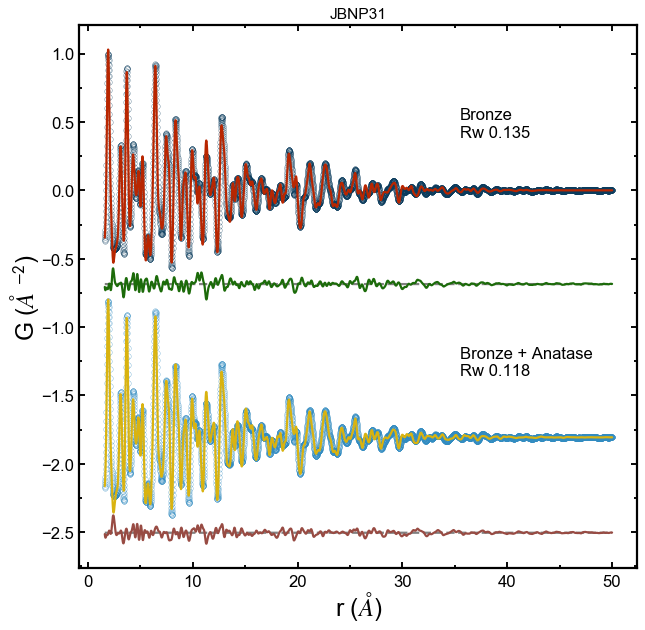

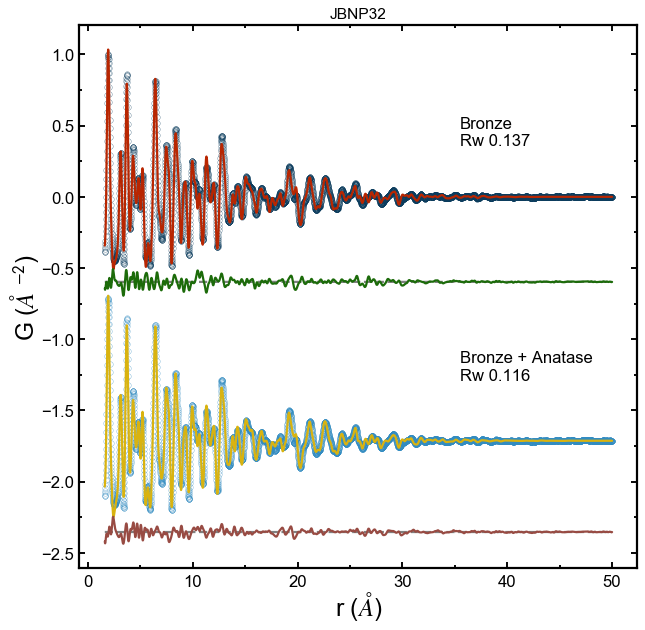

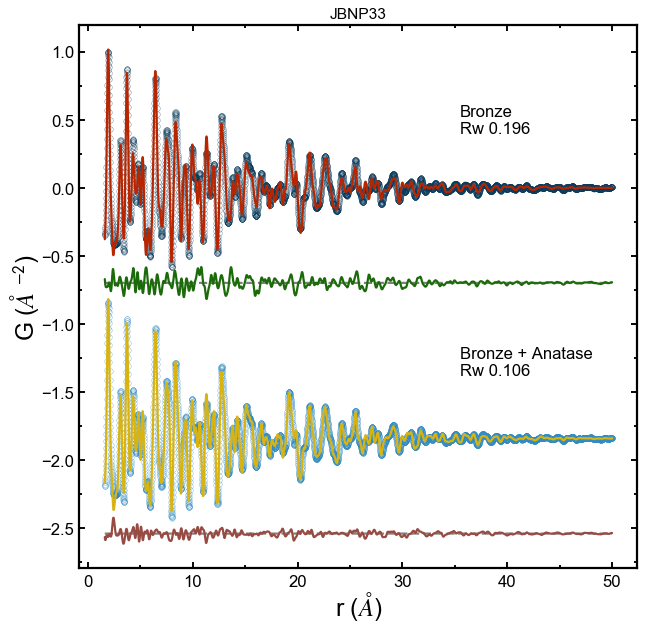

In [21]:
samples = ["JBNP31", "JBNP32", "JBNP33"]
for sample in samples:
    fgrs = DF.loc[sample, ["fgr_twop", "fgr_two_phase"]]
    names = ["Bronze", "Bronze + Anatase"]
    plot_fgr(fgrs, normal=True, auto_rw=True, apos=(.7, .3), names=names)
    plt.title(sample)
    plt.show()

For non-ligand samples, the best model is a two phase model, where one phase is a Bronze with characteristic function of two particle size and the other phase is an Anatase with one particle size.

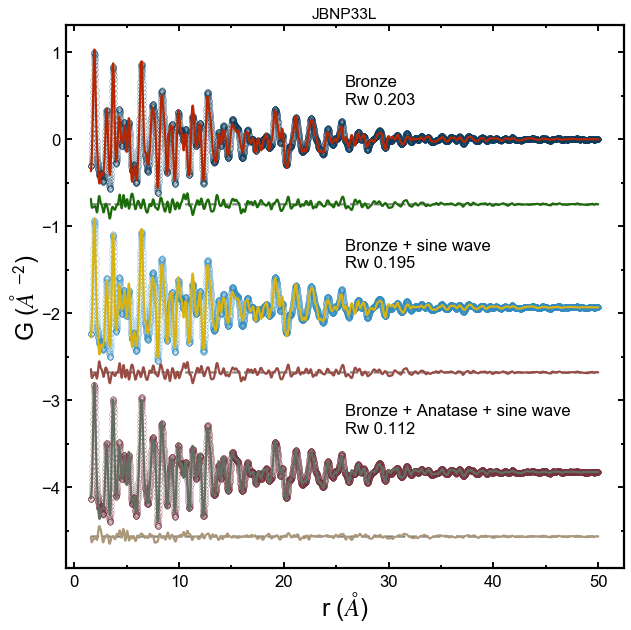

In [22]:
samples = ["JBNP33L"]
for sample in samples:
    fgrs = DF.loc[sample, ["fgr_twop", "fgr_sinwave", "fgr_two_phase_sine_wave"]]
    names = ["Bronze", "Bronze + sine wave", "Bronze + Anatase + sine wave"]
    plot_fgr(fgrs, normal=True, auto_rw=True, apos=(.5, .3), names=names)
    plt.title(sample)
    plt.show()

For ligand sample JBNP33L, the best model is a two phase model with an additional modulation curve, where one phase is a Bronze with characteristic function of two particle size and the other phase is an Anatase with one particle size and the modulation curve is an exponential decaying sine wave.

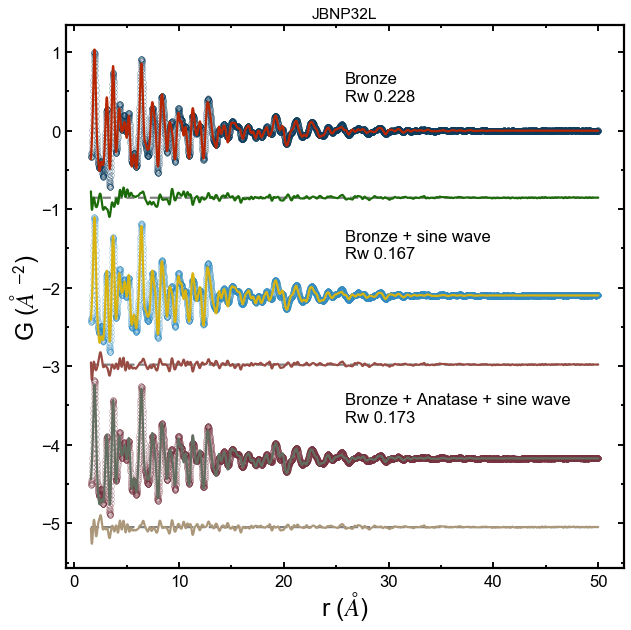

In [23]:
samples = ["JBNP32L"]
for sample in samples:
    fgrs = DF.loc[sample, ["fgr_twop", "fgr_sinwave", "fgr_two_phase_sine_wave"]]
    names = ["Bronze", "Bronze + sine wave", "Bronze + Anatase + sine wave"]
    plot_fgr(fgrs, normal=True, auto_rw=True, apos=(.5, .3), names=names)
    plt.title(sample)
    plt.show()

For ligand sample JBNP32L, the best model is a one phase model, which is a Bronze phase with a characteristic function with two particle size. It is interesting that Anatase failed to fit the residuals only in JBNP32L.

### Why did the anatase fail to fit the JBNP32L?

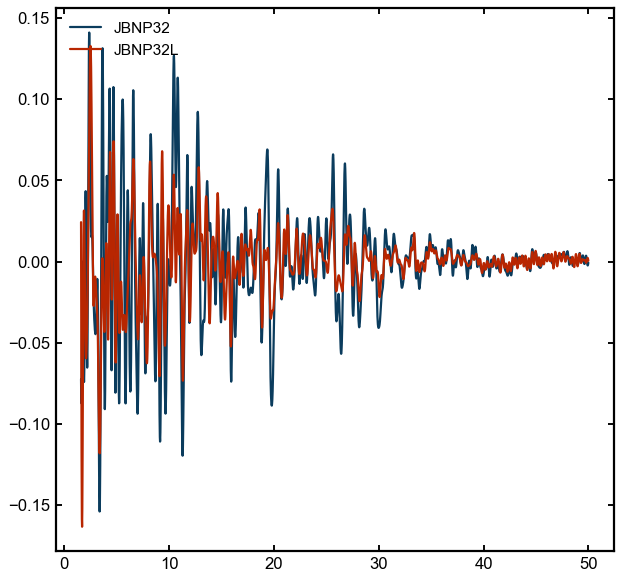

In [24]:
samples = ["JBNP32", "JBNP32L"]
fit_mods = ["fgr_twop", "fgr_sinwave"]
fgrs = [DF.loc[sample, fit_mod] for sample, fit_mod in zip(samples, fit_mods)]
rs, _, _, gdiffs = H.load_fgr(fgrs)

for sample, r, gdiff in zip(samples, rs, gdiffs):
    plt.plot(r, gdiff, label=sample)

plt.legend(loc=2)
plt.show()

# Compare results from lognoraml and spherical

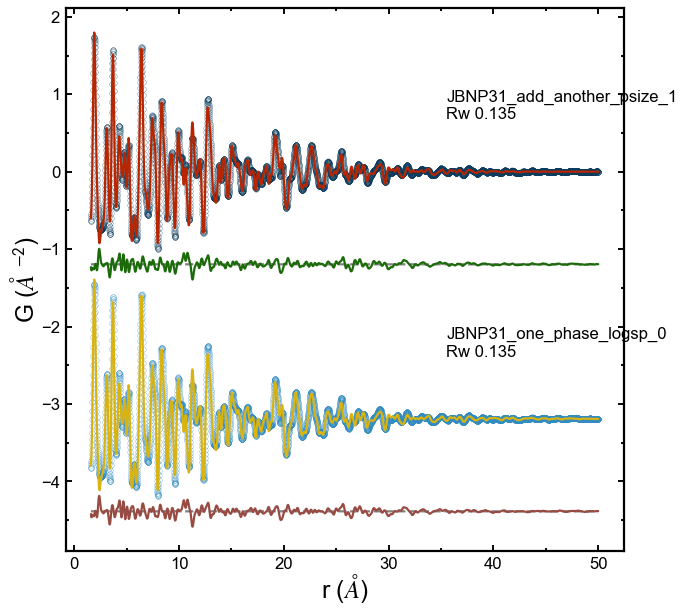

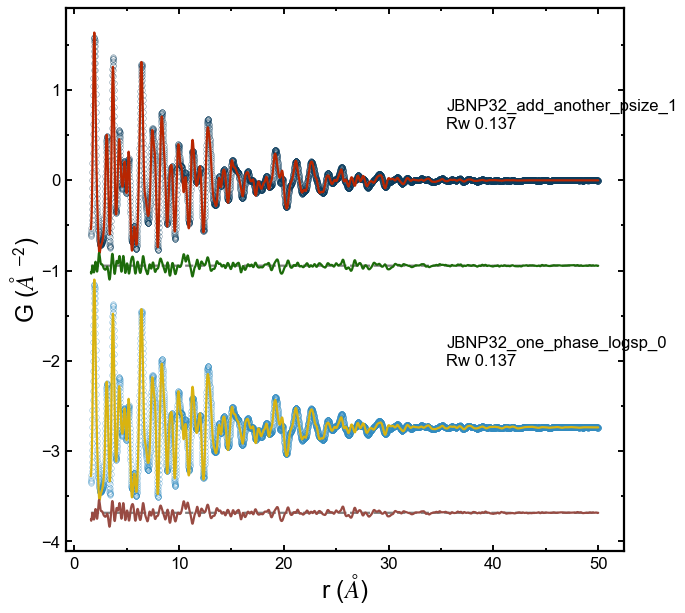

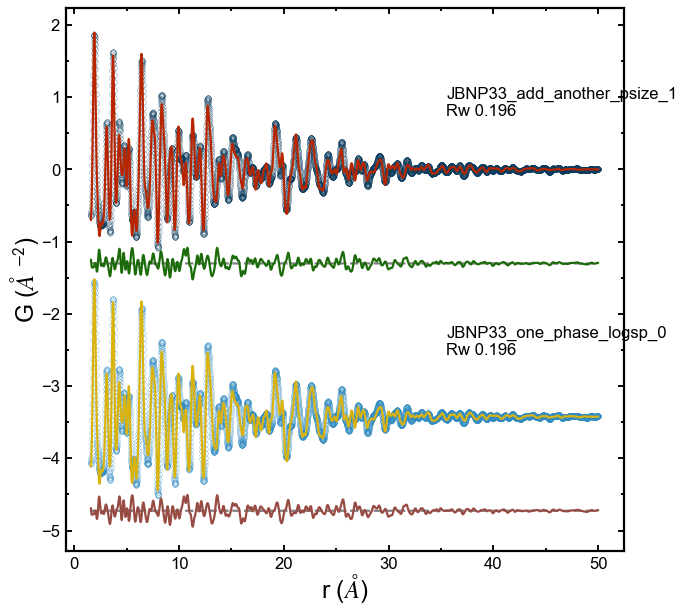

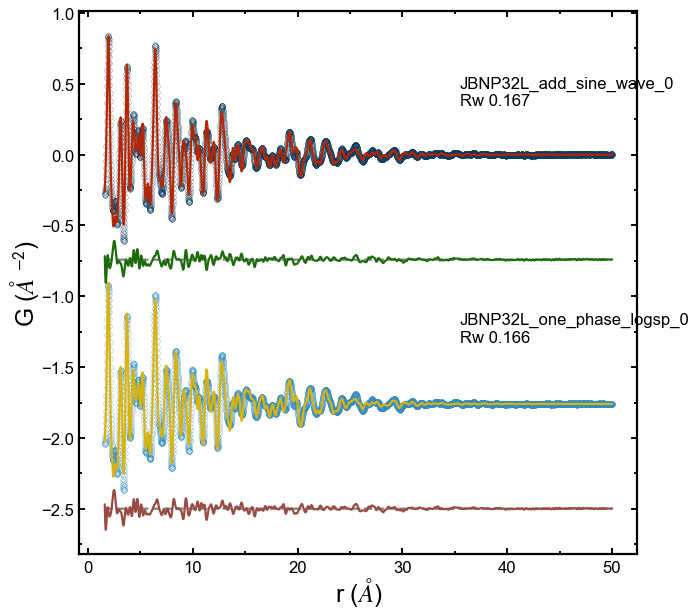

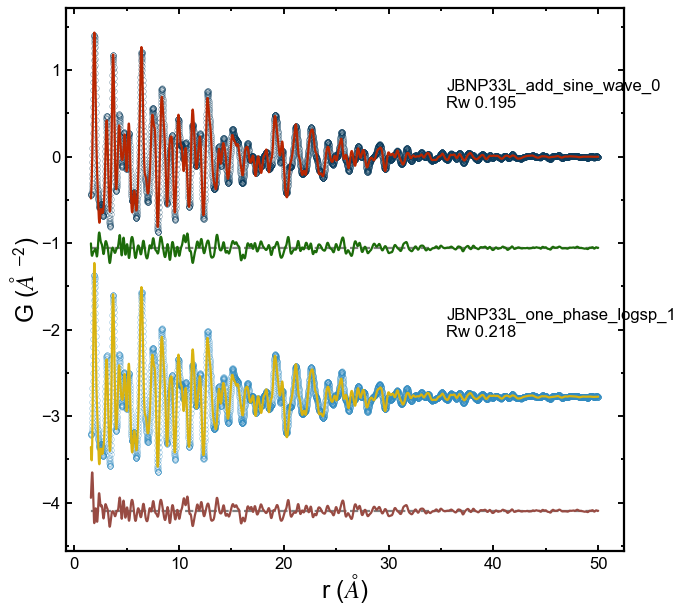

In [25]:
# compare lognormal with twopsize
samples = ["JBNP31", "JBNP32", "JBNP33"]
for sample in samples:
    fittings = ["fgr_twop", "fgr_one_phase_logsp"]
    plt.figure()
    plot_fgr(DF.loc[sample, fittings], auto_rw=True)
    
# compare lognormal with twopsize
samples = ["JBNP32L", "JBNP33L"]
for sample in samples:
    fittings = ["fgr_sinwave", "fgr_one_phase_logsp"]
    plt.figure()
    plot_fgr(DF.loc[sample, fittings], auto_rw=True)

(1) The result is almost identical, expect the the JBNP33L, where the logsp fitting miss a part of the firt peak.

(2) It is not distinguishable between the two psize and lognormal just looking at the residuals.

In [26]:
dfs = [pd.read_csv(csv_file, index_col=0) for csv_file in DF["csv_one_phase_logsp"]]
res_logn = pd.concat(dfs, axis=1, sort=False)
res_logn.columns = DF.index
res_logn

sample             JBNP31     JBNP32L      JBNP32     JBNP33L      JBNP33
Rw               0.135495    0.166245    0.136926    0.217562    0.195569
chi2             7.856450    2.432580    5.486591   14.290837   19.254517
rchi2            0.001638    0.000508    0.001144    0.002982    0.004014
psize_Bronze    28.076314   27.283632   18.489973   41.599959   38.710509
psig_Bronze     10.599059    7.738985    8.880695   10.713798   11.633490
scale_Bronze     0.518404    0.247001    0.504944    0.369667    0.495139
delta2_Bronze    2.569762    2.833779    2.236924    2.964156    2.952274
a_Bronze        12.191220   12.219952   12.204929   12.196784   12.200235
b_Bronze         3.745586    3.758840    3.746683    3.751174    3.748499
c_Bronze         6.490857    6.468269    6.483761    6.483253    6.491686
beta_Bronze    107.027425  107.059050  107.032888  107.109980  107.150781
U33_0_Bronze     0.007566    0.009045    0.009470    0.009021    0.009331
U13_0_Bronze     0.002215    0.002654    0.002774    0.002654    0.002752
U11_0_Bronze     0.007566    0.009045    0.009470    0.009021    0.009331
U22_0_Bronze     0.007566    0.009045    0.009470    0.009021    0.009331
U33_4_Bronze     0.005917    0.007438    0.006278    0.005229    0.005327
U13_4_Bronze     0.001733    0.002182    0.001839    0.001538    0.001571
U11_4_Bronze     0.005917    0.007438    0.006278    0.005229    0.005327
U22_4_Bronze     0.005917    0.007438    0.006278    0.005229    0.005327
U33_8_Bronze     0.024165    0.021057    0.030077    0.020408    0.022183
U13_8_Bronze     0.007076    0.006177    0.008810    0.006004    0.006541
U11_8_Bronze     0.024165    0.021057    0.030077    0.020408    0.022183
U22_8_Bronze     0.024165    0.021057    0.030077    0.020408    0.022183
U33_12_Bronze    0.022880    0.012355    0.022967    0.020957    0.022998
U13_12_Bronze    0.006700    0.003624    0.006727    0.006166    0.006782
U11_12_Bronze    0.022880    0.012355    0.022967    0.020957    0.022998
U22_12_Bronze    0.022880    0.012355    0.022967    0.020957    0.022998
U33_16_Bronze    0.011983    0.023927    0.010740    0.008338    0.007596
U13_16_Bronze    0.003509    0.007019    0.003146    0.002453    0.002240
U11_16_Bronze    0.011983    0.023927    0.010740    0.008338    0.007596
U22_16_Bronze    0.011983    0.023927    0.010740    0.008338    0.007596
U33_20_Bronze    0.014772    0.011674    0.014768    0.012382    0.013084
U13_20_Bronze    0.004326    0.003425    0.004326    0.003643    0.003858
U11_20_Bronze    0.014772    0.011674    0.014768    0.012382    0.013084
U22_20_Bronze    0.014772    0.011674    0.014768    0.012382    0.013084
x_0_Bronze       0.804377    0.801875    0.804001    0.804986    0.805670
z_0_Bronze       0.714562    0.708370    0.713596    0.715083    0.716264
x_4_Bronze       0.601047    0.601756    0.601065    0.602144    0.602098
z_4_Bronze       0.705401    0.706351    0.704516    0.704090    0.703970
x_8_Bronze       0.367200    0.371297    0.373180    0.374152    0.374980
z_8_Bronze       0.986266    0.980542    0.982213    0.987871    0.988380
x_12_Bronze      0.757490    0.750781    0.755603    0.751787    0.752610
z_12_Bronze      0.648740    0.629824    0.652799    0.638963    0.641070
x_16_Bronze      0.562168    0.555825    0.560967    0.562804    0.562623
z_16_Bronze      0.364389    0.350661    0.368383    0.364650    0.365171
x_20_Bronze      0.370345    0.376956    0.374240    0.371754    0.372085
z_20_Bronze      0.291134    0.295422    0.294382    0.285003    0.287670
wl                    NaN    4.774829         NaN    4.721631         NaN
amp                   NaN    0.179749         NaN    0.119078         NaN
dec                   NaN    0.187899         NaN    0.180749         NaN
x0                    NaN   -0.571048         NaN   -0.486567         NaN

In [27]:
# plot distribution
def lognorm(x, psize, psig):
    from scipy.stats import lognorm
    s2 = np.log((psig / psize) ** 2 + 1)
    mu = np.log(psize) - s2/2
    sigma = np.sqrt(s2)
    scale = np.exp(mu)
    return lognorm.pdf(x, sigma, 0., scale)

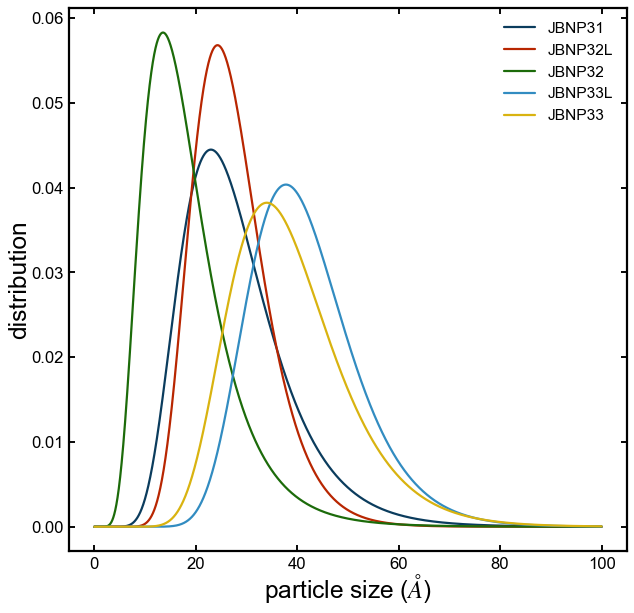

In [28]:
plt.figure()

for sample in res_logn.columns:
    psize = res_logn.loc["psize_Bronze", sample]
    psig = res_logn.loc["psig_Bronze", sample]

    x = np.arange(0., 100.001, 0.01)
    y = lognorm(x, psize, psig)

    plt.plot(x, y, label=sample)

plt.xlabel(r"particle size ($\AA$)")
plt.ylabel(r"distribution")
plt.legend()
plt.show()

(1) Some of the average particel size is too small. It is not a distribution that appears "real".

(2) There may be more distribution that is differnet but still fits the PDFs. It is hard to distinguish which one is true.

(3) It is better to state that the characteristic function is a proximate function because the particle size has a distribution with relatively non-negligble standard deviation.

In [29]:
dfs = [pd.read_csv(csv_file, index_col=0) for csv_file in DF["csv_twop"]]
res_twop = pd.concat(dfs, axis=1, sort=False)
res_twop.columns = DF.index
res_twop

sample       JBNP31     JBNP32L      JBNP32     JBNP33L      JBNP33
Rw         0.135331    0.227805    0.136600    0.203166    0.195614
chi2       7.837393    4.567700    5.460493   12.462101   19.263378
rchi2      0.001634    0.000952    0.001139    0.002598    0.004017
frac_1     0.301820    0.561657    0.469001    0.341041    0.297604
psize_1   22.821889   24.806327   20.593023   32.613151   31.851449
psize_2   48.242264   46.597255   45.434738   58.292243   56.889536
scale      0.521480    0.249369    0.500701    0.373966    0.494634
a         12.191105   12.219708   12.204703   12.197257   12.200657
b          3.745574    3.759279    3.746590    3.751188    3.748462
c          6.490840    6.467884    6.484025    6.482739    6.491429
beta     107.026097  107.100311  107.032799  107.116493  107.149980
U33_0      0.007546    0.009200    0.009487    0.009055    0.009348
U13_0      0.002210    0.002705    0.002779    0.002665    0.002757
U11_0      0.007546    0.009200    0.009487    0.009055    0.009348
U22_0      0.007546    0.009200    0.009487    0.009055    0.009348
U33_4      0.005910    0.007261    0.006300    0.005212    0.005344
U13_4      0.001731    0.002135    0.001845    0.001534    0.001576
U11_4      0.005910    0.007261    0.006300    0.005212    0.005344
U22_4      0.005910    0.007261    0.006300    0.005212    0.005344
U33_8      0.024160    0.020556    0.030237    0.020382    0.022149
U13_8      0.007074    0.006045    0.008857    0.005999    0.006531
U11_8      0.024160    0.020556    0.030237    0.020382    0.022149
U22_8      0.024160    0.020556    0.030237    0.020382    0.022149
U33_12     0.022921    0.012300    0.023022    0.020472    0.022567
U13_12     0.006711    0.003617    0.006744    0.006025    0.006654
U11_12     0.022921    0.012300    0.023022    0.020472    0.022567
U22_12     0.022921    0.012300    0.023022    0.020472    0.022567
U33_16     0.011958    0.020443    0.010762    0.008174    0.007643
U13_16     0.003501    0.006011    0.003152    0.002406    0.002254
U11_16     0.011958    0.020443    0.010762    0.008174    0.007643
U22_16     0.011958    0.020443    0.010762    0.008174    0.007643
U33_20     0.014832    0.012137    0.014837    0.012571    0.013067
U13_20     0.004343    0.003569    0.004346    0.003700    0.003853
U11_20     0.014832    0.012137    0.014837    0.012571    0.013067
U22_20     0.014832    0.012137    0.014837    0.012571    0.013067
x_0        0.804381    0.802112    0.803989    0.805061    0.805664
z_0        0.714596    0.708753    0.713546    0.715207    0.716216
x_4        0.601046    0.601961    0.601047    0.602154    0.602095
z_4        0.705370    0.706742    0.704490    0.704125    0.703979
x_8        0.367074    0.372466    0.373318    0.374490    0.375157
z_8        0.986201    0.980533    0.982237    0.987737    0.988744
x_12       0.757568    0.750098    0.755658    0.751464    0.752380
z_12       0.649027    0.629641    0.652788    0.638847    0.640950
x_16       0.562114    0.554707    0.560957    0.562767    0.562895
z_16       0.364360    0.350530    0.368288    0.364294    0.365249
x_20       0.370369    0.376815    0.374149    0.371813    0.372101
z_20       0.291204    0.295423    0.294367    0.285014    0.287718
delta2     2.545996    2.782841    2.262460    2.946923    2.955638

In [30]:
dfs = [pd.read_csv(csv_file, index_col=0) for csv_file in DF["csv2"]]
res_onep = pd.concat(dfs, axis=1, sort=False)
res_onep.columns = DF.index
res_onep

sample      JBNP31     JBNP32L      JBNP32     JBNP33L      JBNP33
var                                                               
Rw        0.138619    0.232752    0.144891    0.203692    0.196464
psize    40.953124   33.819676   35.147468   48.615605   48.087991
scale     0.497767    0.242040    0.457279    0.367131    0.489308
a        12.192923   12.221793   12.207010   12.198172   12.201173
b         3.745680    3.758682    3.746842    3.751160    3.748413
c         6.490931    6.466033    6.486385    6.482767    6.491574
beta    107.035503  107.106425  107.086855  107.117145  107.149928
U33_0     0.007724    0.009427    0.009695    0.009128    0.009423
U13_0     0.002263    0.002773    0.002849    0.002687    0.002779
U11_0     0.007724    0.009427    0.009695    0.009128    0.009423
U22_0     0.007724    0.009427    0.009695    0.009128    0.009423
U33_4     0.005979    0.007111    0.006631    0.005210    0.005313
U13_4     0.001752    0.002092    0.001948    0.001533    0.001567
U11_4     0.005979    0.007111    0.006631    0.005210    0.005313
U22_4     0.005979    0.007111    0.006631    0.005210    0.005313
U33_8     0.024551    0.020170    0.028550    0.020051    0.022102
U13_8     0.007193    0.005933    0.008389    0.005902    0.006517
U11_8     0.024551    0.020170    0.028550    0.020051    0.022102
U22_8     0.024551    0.020170    0.028550    0.020051    0.022102
U33_12    0.022997    0.013102    0.023376    0.020244    0.022911
U13_12    0.006737    0.003854    0.006868    0.005958    0.006756
U11_12    0.022997    0.013102    0.023376    0.020244    0.022911
U22_12    0.022997    0.013102    0.023376    0.020244    0.022911
U33_16    0.011952    0.019593    0.010759    0.008337    0.007665
U13_16    0.003502    0.005763    0.003161    0.002454    0.002260
U11_16    0.011952    0.019593    0.010759    0.008337    0.007665
U22_16    0.011952    0.019593    0.010759    0.008337    0.007665
U33_20    0.014474    0.012828    0.013957    0.012314    0.012917
U13_20    0.004240    0.003773    0.004101    0.003624    0.003809
U11_20    0.014474    0.012828    0.013957    0.012314    0.012917
U22_20    0.014474    0.012828    0.013957    0.012314    0.012917
x_0       0.804356    0.802013    0.804476    0.804952    0.805546
z_0       0.714398    0.708402    0.713387    0.715055    0.716129
x_4       0.601019    0.601967    0.601177    0.602158    0.602086
z_4       0.705453    0.707003    0.704939    0.704181    0.704046
x_8       0.368310    0.373259    0.375353    0.374703    0.375209
z_8       0.986699    0.980308    0.984193    0.987873    0.988372
x_12      0.756826    0.750365    0.754744    0.751199    0.752378
z_12      0.646983    0.630943    0.646384    0.638333    0.640710
x_16      0.562646    0.554472    0.562770    0.562866    0.562678
z_16      0.364585    0.353572    0.366284    0.364468    0.365345
x_20      0.370413    0.376594    0.372934    0.371830    0.372090
z_20      0.291060    0.295031    0.292233    0.285173    0.287741
delta2    2.753854    2.684366    2.879537    2.964229    2.957251

In [31]:
import diffpy.srfit.pdf.characteristicfunctions as F

def two_psize(r, frac1, psize1, psize2):
    return frac1 * F.sphericalCF(r, psize1) + (1 - frac1) * F.sphericalCF(r, psize2)

def lognorm_psize(r, psize, psig):
    return F.lognormalSphericalCF(r, psize, psig)

/anaconda3/envs/diffpy/lib/python3.7/site-packages/diffpy.srfit-3.0.0-py3.7.egg/diffpy/srfit/pdf/characteristicfunctions.py:181: RuntimeWarning: divide by zero encountered in log
  - 0.75*r*erfc((-mu-2*s*s+log(r))/(sqrt2*s))*exp(-mu-2.5*s*s)


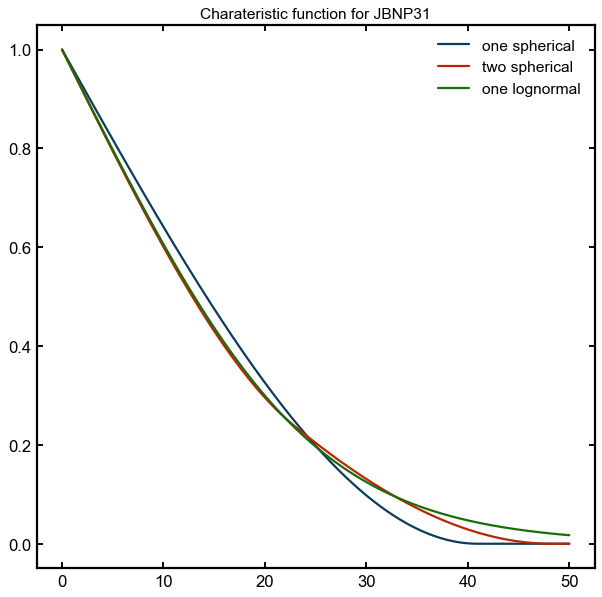

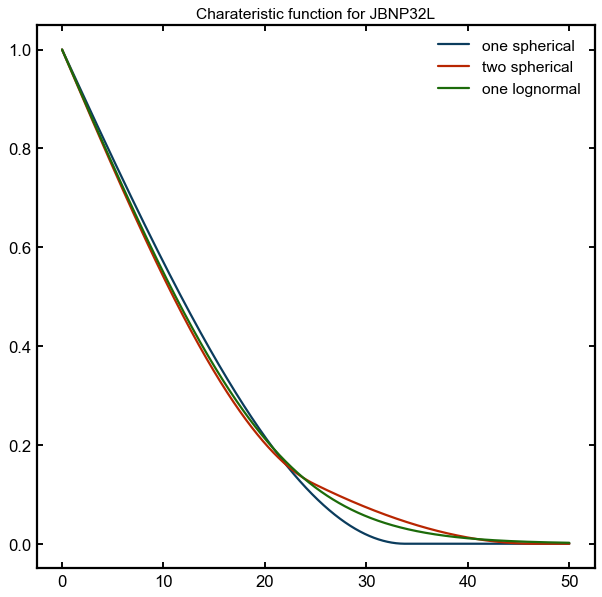

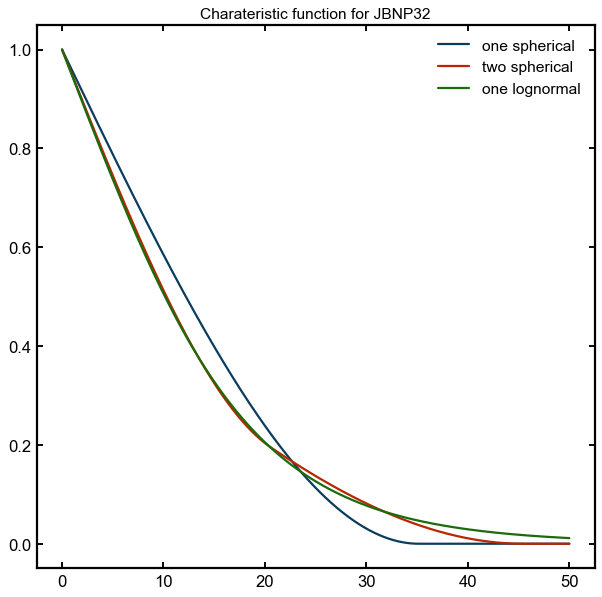

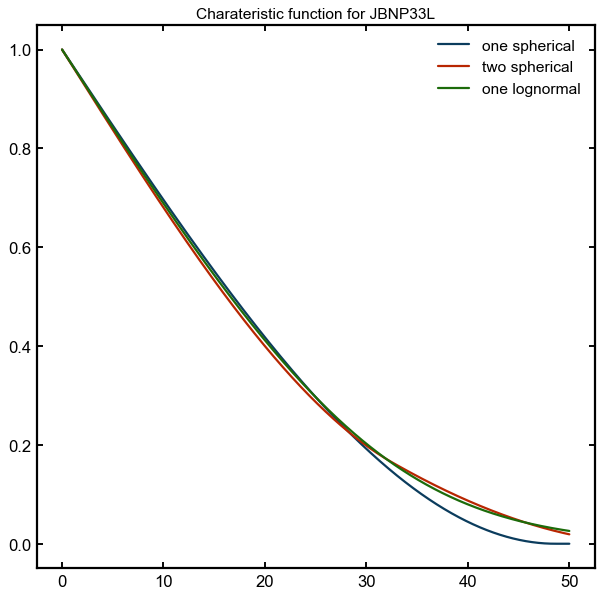

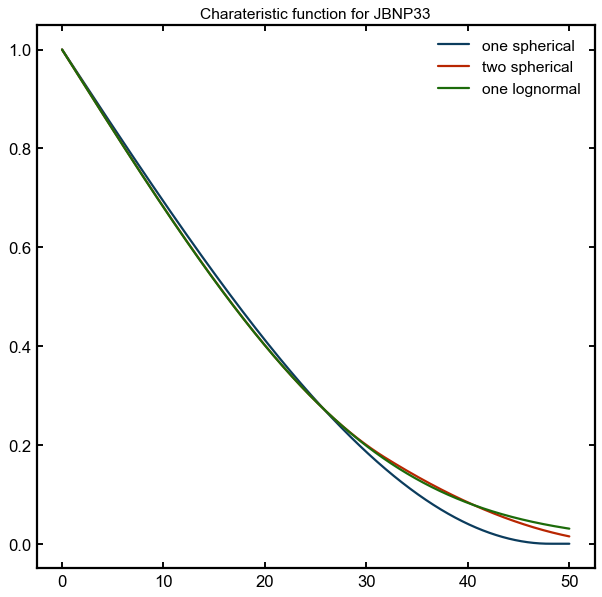

In [32]:
for sample in DF.index:
    psize0 = res_onep.loc["psize", sample]
    
    frac1 = res_twop.loc["frac_1", sample]
    psize1 = res_twop.loc["psize_1", sample]
    psize2 = res_twop.loc["psize_2", sample]

    psize = res_logn.loc["psize_Bronze", sample]
    psig = res_logn.loc["psig_Bronze", sample]

    r = np.arange(0., 50.001, .01)
    f_onep = F.sphericalCF(r, psize0)
    f_twop = two_psize(r, frac1, psize1, psize2)
    f_logn = lognorm_psize(r, psize, psig)

    plt.figure()
    plt.title(f"Charateristic function for {sample}")
    plt.plot(r, f_onep, label="one spherical")
    plt.plot(r, f_twop, label="two spherical")
    plt.plot(r, f_logn, label="one lognormal")
    plt.legend()
    plt.show()